# Lab 4 – Introduction to CNNs with PyTorch

---

How to Use This Notebook
---

**Recommended Setup**
- For the best experience, **run this notebook on [Google Colab](https://colab.research.google.com/)**—especially if your local machine is slow.  
- In Colab, **enable GPU support** by going to:  
  `Runtime > Change runtime type > Hardware accelerator > GPU`


**Homework Tasks**

 - Homework tasks are clearly marked throughout the notebook in the following format:

   > ---

   > <span style="color:red"><b>TASK X</b> - [<i>some text</i>]:</span>

   > ---

   > ```Your code ....```

   > ---

   > *End of Task X.* [*Instructions for passing*]

 - For each task:
   - **Complete the code** where indicated.
   - **Upload the required results** from each task to **Homework 2 – Code** on [NextIlearn](https://nextilearn.dsv.su.se).

 - Once you've finished all the tasks:
   Submit your **entire completed notebook (including your code!)** to **Homework 2 – Notebook** on [NextIlearn](https://nextilearn.dsv.su.se).

**Important:**  
Your submission will **only be graded if both files** (code + notebook) are uploaded **before the deadline**. Late submissions are **not accepted**, regardless of technical issues like bad internet connection.

---




In this lab, we will explore **Convolutional Neural Networks (CNNs)** using **PyTorch**. This lab is hands-on and designed to be run during class time. Each step is followed by detailed explanations and code examples.





## Objectives
- Understand CNN architecture and its components
- Load and preprocess image data using PyTorch
- Build and train a simple CNN
- Evaluate performance on a test set

### Larger and more complex image dataset

In Fashion MNIST classification, the subject is always in the center of a 28x28 image. This means the network only needs to get important features from a fixed area.

However, in this section, we  will use the **CIFAR-10** dataset which contains 60,000 32x32 color images (RGB) in 10 classes, with 6,000 images per class. We will train a Convolutional Neural Network to recognize features in an image where the subject can be anywhere, and the network is trained to recognize features that determine which is which.

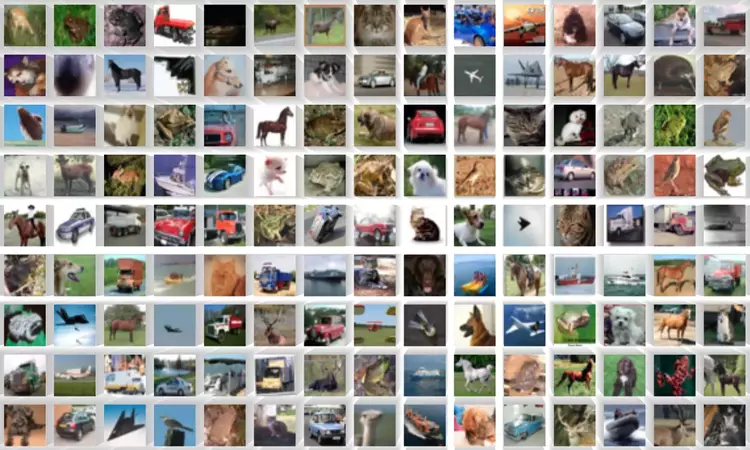

### matplotlib中常用的绘图方法，当然记住还有boxplot,heatmap这种在seaborn中的

**当然记住还有我们经常使用的`figure()`**



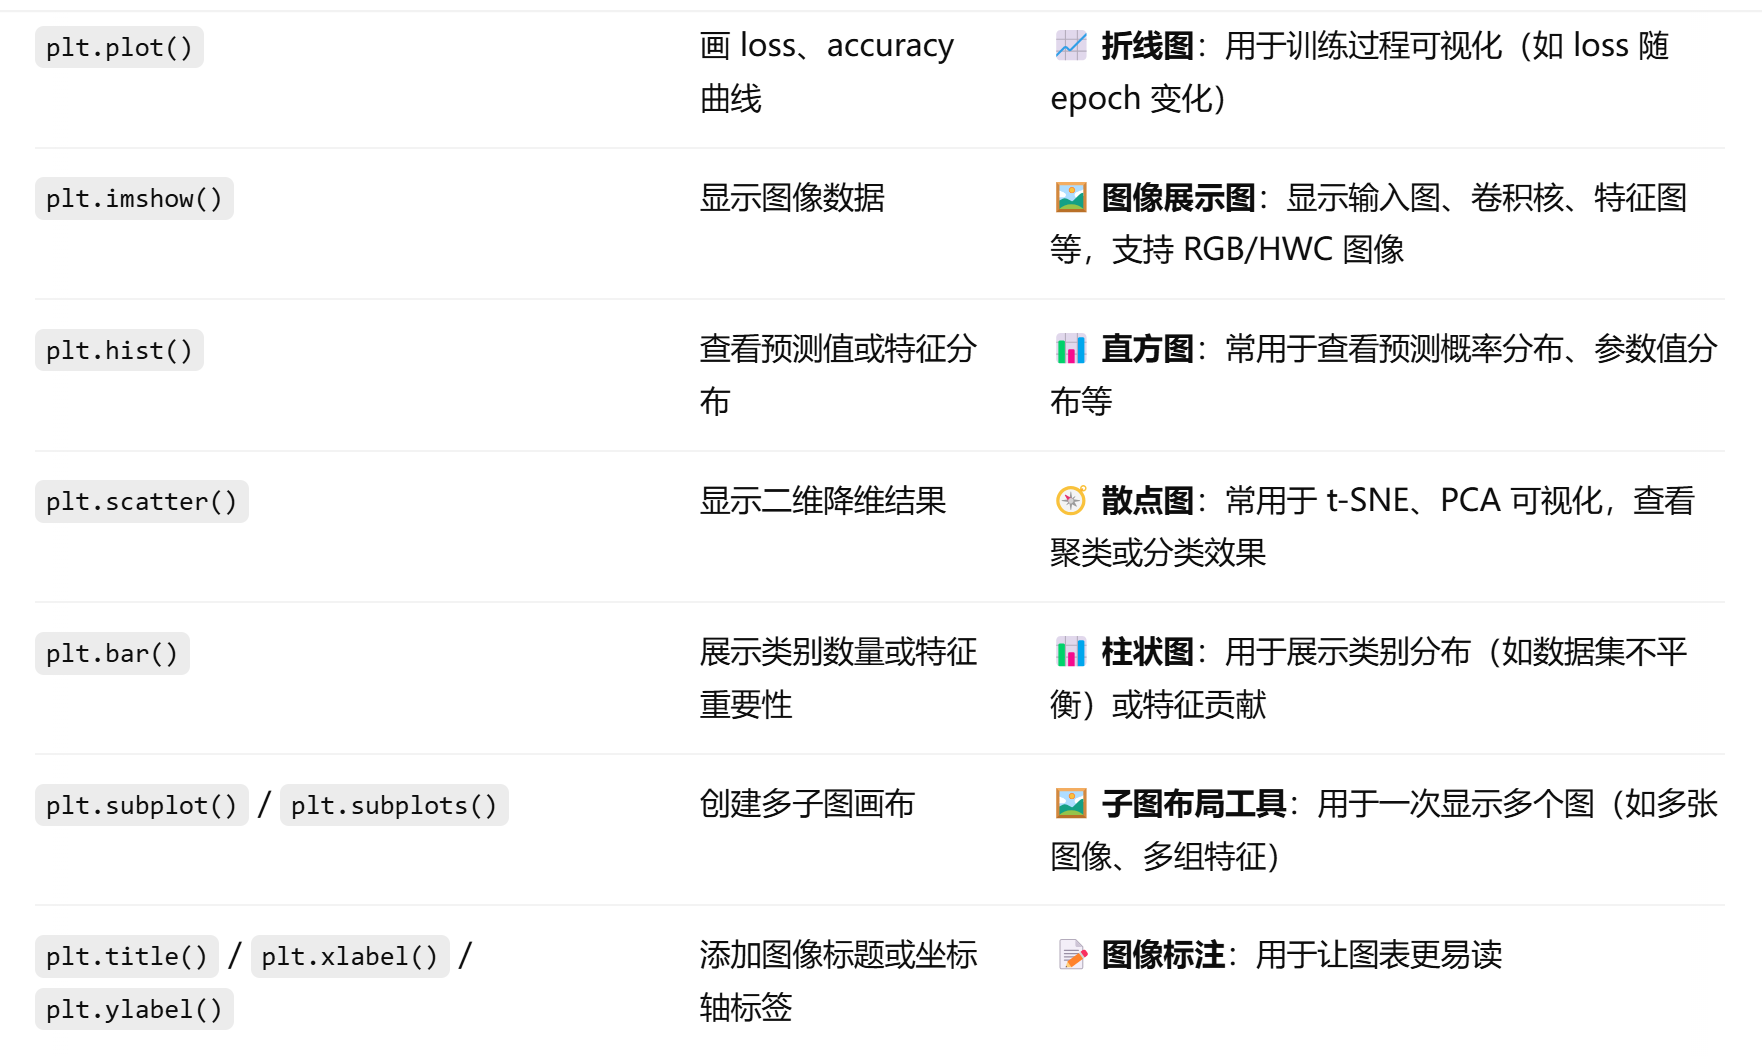

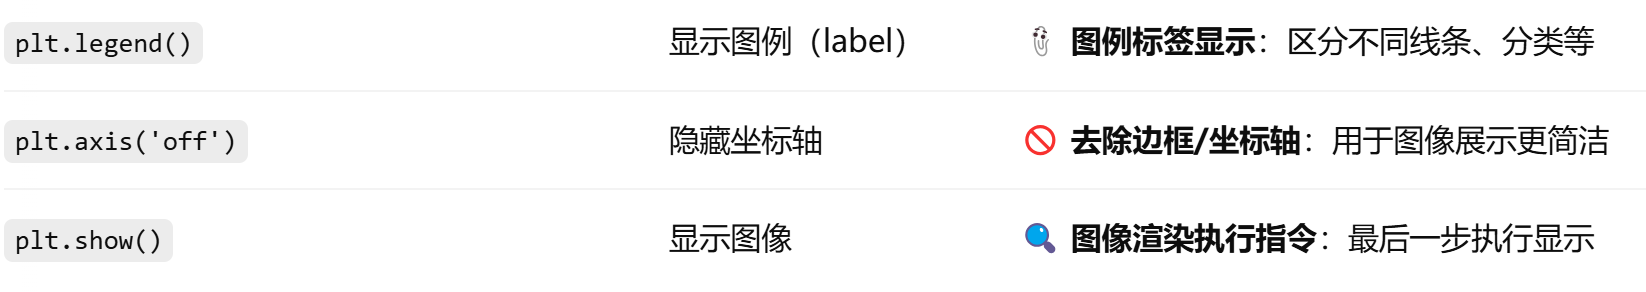

### 但是要记住，我们的一个画布，一个figure是可以同时画多个图上去的，只要我们不调用新的figure,那么我们画的图一直在这个同一个地方

* 我们画图一般是先创建画布`figure()`单个画布，`subplots(行，列，figuresize=())`单个画布，多个独立的图，然后使用画图，`plot()`等，或者直接使用`imshow()`显示一张图，最后我们直接使用show显示图

* 注意，使用subplot时，返回的值为（figure, axes）figure是我们整体的画布对象，然后axes是我们的子图的数组

* 如果我们的subplots(**行为一**，**或是列为一**)的时候，我们的图像是一个numpy数组，只能使用一个index进行访问，例如：`axes[0]`,`axes[1]`,但是当我们的图像是一个行和列都是大于一的情况下，我们的图像的访问就可以：`axes[0][1]`

  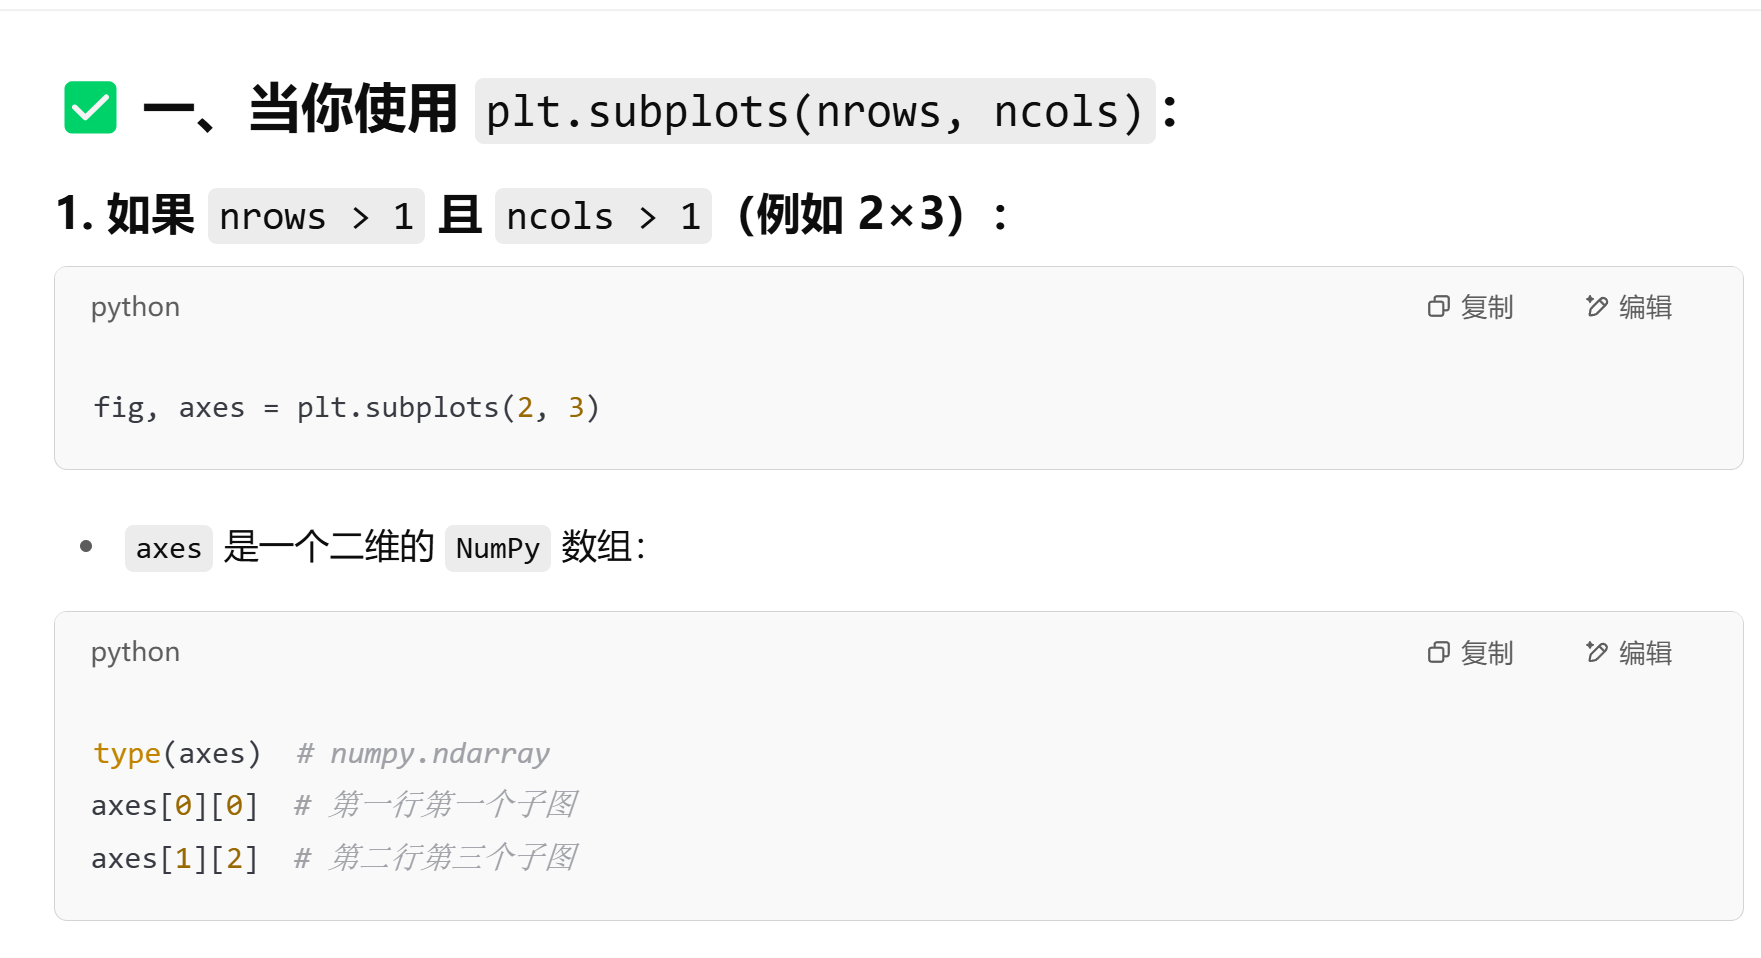

  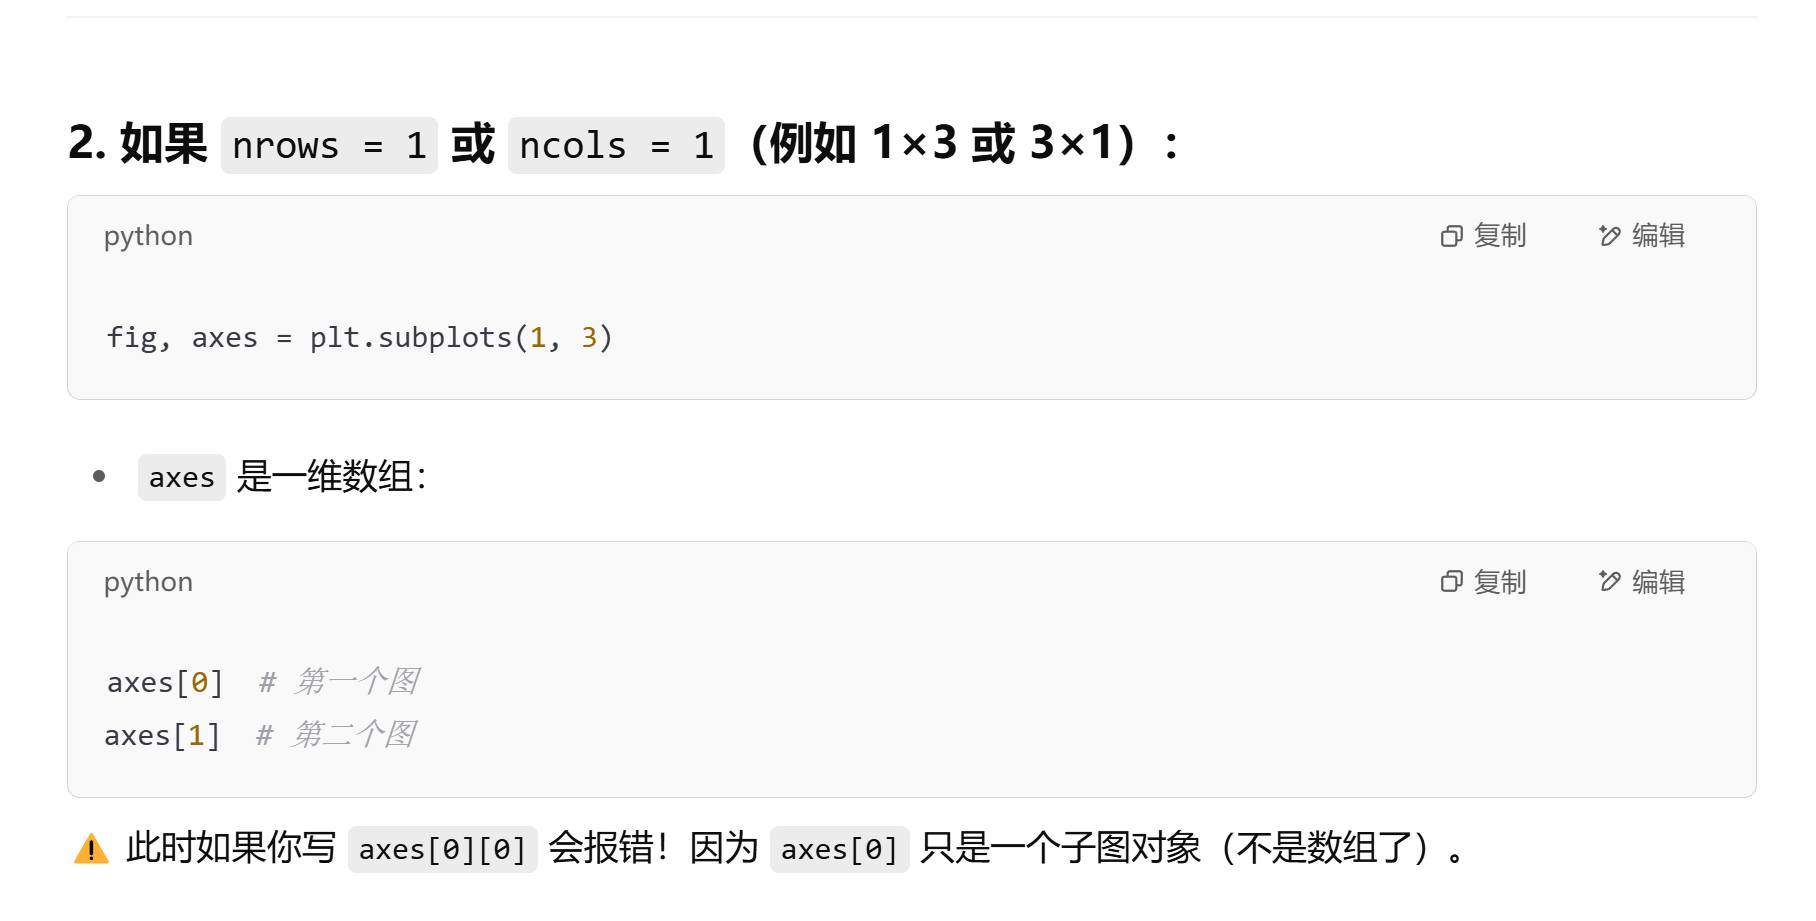

### 使用`matplotlib`画图的一般的步骤：

* 首先使用`plt.figure()`或是`plt.subplots()`创建画布空间，多个子图时候使用我们的subplots()，只有少量的图形的时候使用我们的figure

* 然后使用我们的画图方法，这里以我们的`plot()`为例子，很多的画图方法都有`label`这个参数, 如果我们设定了`label`这一个参数，并且我们的一个绘图空间的一个图中包括了多个不同的标签，那么我们使用`plt.legend()`的时候可以自动对我们的图像进行分类

* 我们的画图方法中一般还有着颜色`color`，以及我们的透明度`alpha`这两个比较重要的参数，别忘了`label`

* 画图完了之后我们可以设置我们的图的标题横坐标纵坐标等，`plt.title("A simple line plot")`，`plt.xlabel("X-axis")`，`plt.ylabel("Y-axis")`，以及使用我们的`plt.legend()`方法，如果在绘图函数（如 plot()）中使用了 label="xxx" 参数，legend() 会将这些线条按 label 分类并显示图例。

* 我们的图像可以使用`plt.tight_layout()` 避免我们的图像遮盖掉标签

* 最后使用`plt.show()`显示我们的图像，但是一般都不用了，都会自动调用

### 创建卷积神经网络的一般的步骤：

* 数据的处理和加载：
  
* 分批加载数据，使用dataloader等加载我们的数据，防止我们的数据过多导致内存爆炸

* 定义神经网络，**输入层**-**卷积层**-进行BatchNor2d标准化数据，降低计算量-**激活函数**，添加非线性特征-**池化数据**,进一步降低计算量-**卷积网络的随机神经元舍弃**降低模型的过拟合风险-**展平数据**方便输入全连接网络-**全连接网络输入层**输入数据-**激活函数**-**全连接层的随即神经元丢弃**-**输出层**，输出的样本的数量一般是标签的数量

* 前向传播，得到我们的输出

* 计算我们的loss，并且计算梯度

* 反向传播，更新梯度

* 使用优化器根据梯度优化参数

* 有时候会储存训练loss，并且和后面的验证loss进行比较，训练loss是使用本轮的模型的参数预测训练集的标签，并且计算loss

* 进行验证，切换为评估模式，使用模型本轮的参数预测我们的验证集的标签，并计算我们的模型的验证loss，储存，一次epoch进行一次评估

* 训练完成，进行最后的测试，加载测试集，使用模型预测结果，计算loss，得到最终的准确率和F1分数

In [21]:
# Import libraries
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Step 1: Load and Transform the CIFAR-10 Dataset

CIFAR-10 is a collection of 60,000 32x32 color images in 10 classes, with 6,000 images per class.
We will:
- Normalize the images to have zero mean and unit variance
- Use PyTorch's built-in dataset and dataloader utilities
- Load both training and test sets

### Normalization
Here, we apply transformations to resize images, convert them to tensors, and normalize. Then we load the CIFAR-10 dataset and preparing DataLoader for batch processing.

### 标准化和归一化
* 什么是标准化？
  标准化是我们把数据变成均值为0，标准差为1的情况，这样的话，我们的数据的尺度就会相同，不需要单独给每一个变量设定一个单独的学习率，模型也不会偏心于值较大的数据

* 什么是归一化？
  将我们的数据的值的范围缩小到0到1，让我们可以更加快捷的运算，避免了极值的影响


In [22]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize RGB channels
])

#Compose方法是定义一个变换管道，我们所有的数据的变化的操作都在里面进行
#我们的ToTensor把数据转化为Tensor类型，并且进行了自动归一化
#Normalize是进行了标准化，这些数据都是固定的，图像数据以后就这样写

### 为什么不用传统的StandardScaler？

* 因为StandardScaler 针对于表格数据，对于图像数据表现很差，Normalize是专门用来对图像标准化的类

In [23]:
# Download the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Download the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [24]:
# Class names for CIFAR-10 labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [25]:
# Split the training dataset into training and validation sets (e.g., 80% train, 20% val)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = torch.utils.data.random_split(trainset, [train_size, val_size])

#random_split方法的第一个参数是数据集，第二个是一个列表，元素个数不限，总和为len(dataset)
#我们的类型提示中：lengths: Sequence[Union[int, float]]
#Sequence(列表或元组)，Union（多种数据类型之一），[int, float]（int或float型）
#Union[int, float]接受int和float的输入
#另外random_split每次是默认打乱的

In [26]:
# Create DataLoaders for training, validation and test subsets
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

## Step 2: Visualize Some Images

Before training our CNN, it's helpful to **visualize the data** we're working with.
We'll define a helper function to show a few sample images along with their corresponding labels.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5178571..1.82].


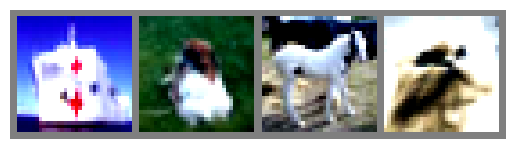

ship The class lables are:dog The class lables are:horse The class lables are:cat


In [27]:
# Helper function to unnormalize and show an image
def imshow(img):
    #记住就行，一般都是除以二加0.5
    img = img / 2 + 0.5  # Unnormalize from [-1, 1] to [0, 1]
    #转换我的tensor为numpy数组，matplotlib才支持
    npimg = img.numpy()
    
    ##把图像从 CHW (channel, height, width) 格式转换为 HWC，这是 matplotlib 显示图像所需格式。
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from CHW to HWC for plotting
    plt.axis('off')
    plt.show()


# Get a batch of training images
#Cifer数据集的__getitem__返回（图像，标签）
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show the first 4 images from the batch
imshow(torchvision.utils.make_grid(images[:4]))
# Print the corresponding class labels
print(' The class lables are:'.join(f'{classes[labels[j]]}' for j in range(4)))

为什么要使用这么麻烦？先处理了数据再还原数据，有什么意义？我觉得其实可忽略。最多就是可以检查变换有无出错，查看机器看到的是哪些数据，当然机器看到的其实是标准化后的数据，我个人认为没什么意义，只是给我们讲解一个例子罢了

## Step 3: Define a Simple Convolutional Neural Network

We define our CNN model using `nn.Module`. It consists of:
- One convolutional layer followed by ReLU and max pooling
- Two fully connected layers

This simple architecture is good for learning and experimentation.

##How Convolutional Neural Networks Work?


Convolutional neural networks (CNNs) are commonly used for image classification tasks. At a high level, CNNs contain three main types of layers:

- Convolutional layers: Apply convolutional filters to the input to extract features. The neurons in these layers are called filters and capture spatial patterns in the input.（卷积层）
- Pooling layers: Downsample the feature maps from the convolutional layers to consolidate information. Max pooling and average pooling are commonly used strategies.（池化层）
- Fully-connected layers: Take the high-level features from the convolutional and pooling layers as input for classification. Multiple fully-connected layers can be stacked.（多个全连接层可以堆叠使用）

The convolutional filters act as feature detectors, learning to activate when they see specific types of patterns or shapes in the input image. As these filters are applied across the image, they produce feature maps that highlight where certain features are present.（filter就是卷积筛选器，其实就是我们的kernel，按照一定的规则来提取我们的特征）

![CNN Building GIF](https://www.kdnuggets.com/wp-content/uploads/awan_building_convolutional_neural_network_pytorch_1.gif)


Padding involves adding extra pixels around the input image’s border.
Padding ensures that the filter fits properly over the image, especially at the edges. Without padding, the feature map’s size reduces after each convolution operation(步长stride为1的情况下，如果设置我们的padding为1的话，卷积输出的图像的大小还是为原来的大小)

 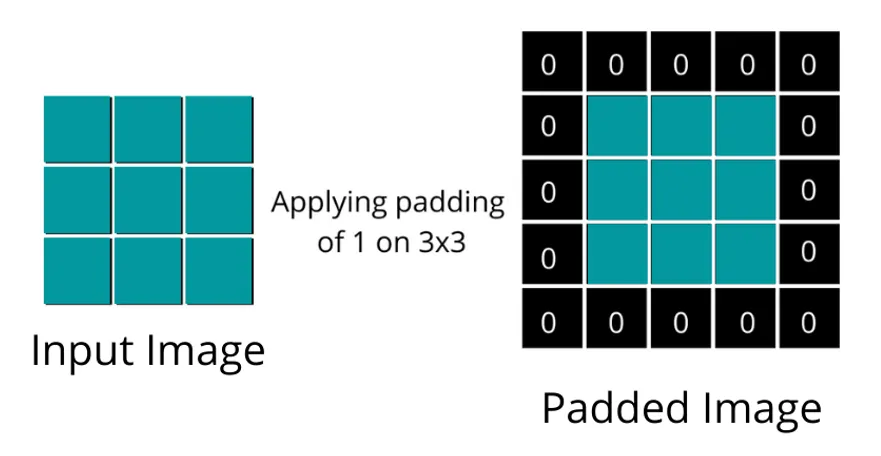

Max pooling takes the maximum value from each patch of the feature map.
Average pooling takes the average value from each patch of the feature map.

This operation reduces the size of the feature map by half, both horizontally and vertically, but retains the most prominent features.

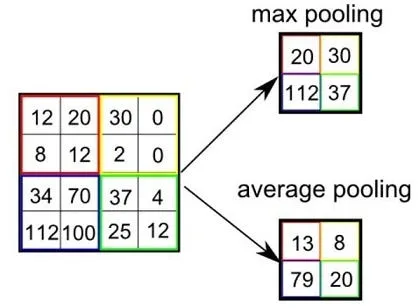

**注意我们如果使用了多层的kernel进行卷积的话，最后pytorch会把所有的卷积的结果加在一起然后这才是我们的卷积的结果**

In [28]:
#这是创建了一个神经网络结构，继承Module,实现init和forward
class SimpleCNN(nn.Module):
    def __init__(self):
        #这里调用这个super()是兼容性较高的写法，python3中支持
        #super().__init__()自动传参，我们不用下面那个
        super(SimpleCNN, self).__init__()
        
        # First convolutional block
        #这一句指定创建一个2d卷积层
        #in-channels(输入通道数，RGB有三个)
        #out_channels(指定了我们的kernel的数量)
        #kernel_size(指定我们的卷积核的面积为3*3)
        #padding(指定我们的图像周围加上一圈0)
        #这一步每一个batch会输出32个32*32的图像
        #我们有32个kernel，然后因为加上了padding，横向滑动32次，纵向32次
        #返回的图像就有32个32*32的图像
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)

        #这一步是对卷积后的输出的数据进行标准化，让模型表现更稳定
        #其中的32是指有32个数据，是上面卷积层输出的32个图像
        #这个数字和上面的out_features相同
        self.bn1 = nn.BatchNorm2d(32)

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Max pooling and 
        #定义了一个池化层，第一个参数是我们的池化层的大小为2*2
        #第二个参数是指我们的步长为2，不会有重叠池化
        #池化的窗口类似于卷积的kernel
        self.pool = nn.MaxPool2d(kernel_size= 2, stride= 2)

        #设定我们的舍弃值为0.25，会随机舍弃神经元
        self.dropout = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))  # Conv1 -> BN -> ReLU -> Pool
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))  # Conv2 -> BN -> ReLU -> Pool
        x = self.dropout(x)  # Apply dropout after conv blocks

        #我们的全连接层只接受一维向量的输入，转化这个三维的图像成向量
        x = x.view(-1, 64 * 8 * 8)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout_fc(x)  # Dropout in FC layer
        x = self.fc2(x)
        return x

### view和reshape
* ✅ `view()` 和 `reshape()` 的每一个参数含义：
这两个方法都用来改变张量（Tensor）的形状。二者参数格式和含义是一样的。
语法示例：

x = x.view(a, b, c, ...)
x = x.reshape(a, b, c, ...)
这些参数 a, b, c, ... 就是你想要的新形状，每个参数都表示一个维度。

* ✳️ 特殊参数 -1 是什么意思？
在 `view()` 和 `reshape()` 中：

`x.view(-1, 4096)`
这里的 -1 不是负数含义，而是告诉 PyTorch：

“我不管这一维是多少，你自动帮我算，前提是总元素数量不变”。
所以-1就是这个参数让pytorch自动推断的意思

* ✅ 举个例子来说明：
假设你有一个张量：

`x.shape = (16, 64, 8, 8)`
总元素数是：
16 * 64 * 8 * 8 = 65536

你现在想展平成一个二维张量用于全连接层：

`x = x.view(-1, 64 * 8 * 8)`   也就是 view(-1, 4096)
结果就是：

x.shape → (16, 4096)
其中 -1 被自动推断为 16。

* shape的含义
  x.shape = (batch_size, channels, height, width)
  分别是我们的batch的容量，通道数，长/高，宽

### 几个注意的问题

* 我们的池化可以重叠吗？
* 我们的卷积层输入输出的通道数量，参数是定死了只能向上面一样吗？还是说可以选择其他的
* 我们的全连接层的输入为什么是64x8x8，输出为什么是512
* 为什么我们在卷积层进行一次舍弃，全连接层又进行一次舍弃，为什么不总的进行一次舍弃

1.
首先我们的池化是可以进行有重叠的池化的，这样会让我们的结果更加精细，但是也会让我们的计算难度更高

2.
每一层的输入必须要和上一层的输出的尺寸一样，我们一般的输出有32，64，128

3.
我们的神经网络每一层卷积后都有一层池化，最先进去32x32，池化后是16x16，我们的池化核定义是2*2，步长是2，横向移动32/2次，纵向也相同，最后有64个卷积核，每一个输出的图像是8x8，输出512也可以设置成其他，例如128啊什么的，没有特定的要求

4.
为了分别让卷积层的某些卷积神经元不至于太强，在卷积层定义结束后随机丢弃一次神经元，防止线性层的某些神经元过强，也会在我们的线性层的定义结束后随机丢弃一些神经元

 Model Summary with `torchsummary`

To get a layer-by-layer breakdown of your custom PyTorch model, you can use the `torchsummary` package. This is especially useful to understand the number of parameters, shapes, and types of layers used.

Make sure you have already installed `torchsummary`

In [29]:
from torchsummary import summary

net = SimpleCNN()
#使用的时候记得告诉我们的总结方法我们的第一个输入层输入什么
#这里告诉了输入3通道的长和宽为32的图像
summary(net, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
           Dropout-7             [-1, 64, 8, 8]               0
            Linear-8                  [-1, 512]       2,097,664
           Dropout-9                  [-1, 512]               0
           Linear-10                   [-1, 10]           5,130
Total params: 2,122,378
Trainable params: 2,122,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.88
Params size (MB): 8.10
Estimat

## Step 4: Instantiate the Model, Define Loss Function and Optimizer

Now that we’ve defined our CNN class, we:
- Instantiate the model
- Choose a **loss function** suitable for multi-class classification: `CrossEntropyLoss`
- Use **Stochastic Gradient Descent (SGD)** as our optimizer

These components are necessary to begin training the model.

In [30]:
# Create an instance of our CNN
net = SimpleCNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# Loss functiona, Optimizer and Scheduler
criterion = nn.CrossEntropyLoss().to(device)

#里面的weight_decay是我们的惩罚系数，l2，这个1e-5是经验取值
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)



## Step 5: Train the CNN

We'll train the model over 2 epochs.
In each epoch, we:
- Loop over the training dataset in batches
- Perform a forward pass
- Compute the loss
- Backpropagate the error
- Update the model parameters

We print the loss every 200 mini-batches to track learning progress.

After each training epoch, we also evaluate the model on a separate **validation set**.
This helps monitor the model's generalization and detect overfitting early.

In [31]:
# get gpu if available else cpu:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [32]:
net = net.to(device)

In [33]:
for epoch in range(2):  # loop over the dataset multiple times

    net.train()
    running_loss = 0.0
    #从0开始遍历，得到我们的索引，参数
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        #因为我们的i是从0开始的，所以说第2000个数其实是1999
        #余数为1999的时候，我们的i就是2000
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    # 🔍 Validation phase after each epoch
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_inputs, val_labels in valloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = net(val_inputs)
            vloss = criterion(val_outputs, val_labels)
            val_loss += vloss.item()


            #我们的val_outputs是val_outputs.shape == (batch_size, num_classes)
            #这个max方法是获取我们的最大值和其索引，
            #这里我们省略最大值，只关心索引
            #我们的图片tensor是（每batch样本数，通道数，长，宽）
            #max(张量,dim（维度）)，dim=1是指在行（长）上取最值
            #对一个 shape 为 (D0, D1, D2, ..., Dn) 的张量来说，
            #dim 的可选值是从 0 到 n，每个值表示在哪一维度上进行最大值操作。
            _, predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    #计算验证集的准确率
    val_acc = 100 * correct / total
    #计算验证集的平均损失率
    avg_val_loss = val_loss / len(valloader)

    print(f'Validation after Epoch {epoch + 1} → Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.2f}%\n')

print('Finished Training')


Validation after Epoch 1 → Loss: 1.1964, Accuracy: 56.49%

Validation after Epoch 2 → Loss: 1.0483, Accuracy: 63.36%

Finished Training


## Step 6: Evaluate the Model on Test Data

Now we evaluate the model's performance on **unseen test data**.

We:
- Disable gradient calculation for efficiency
- Predict classes for each test image
- Compare predictions with true labels
- Calculate the overall classification accuracy

In [34]:
# Initialize counters
correct = 0
total = 0

# Turn off gradient tracking for evaluation
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device) #to device
        outputs = net(images)
        #这一步是用来获取我们的输出的最大概率值的标签
        _, predicted = torch.max(outputs.data, 1)  # Get index of max log-probability
        #下面这个直接等同于lables.shape[0]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute and print accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f}%')

Accuracy of the network on the 10000 test images: 63.81%


## Visualizing CNN Kernels and Feature Maps

To understand what the CNN is learning, we can visualize:
- **Kernels (filters)**: The raw weights of convolution layers
- **Feature maps (activations)**: What the filters detect in a specific input image

These help us build intuition about how the model 'sees' the image at each stage.

### 归一化公式
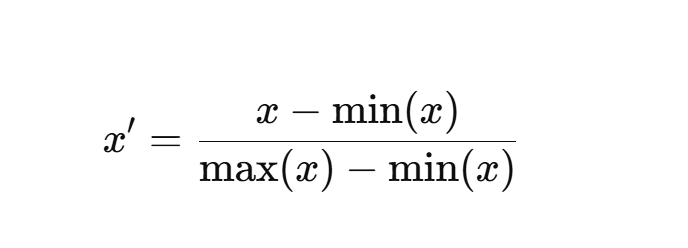

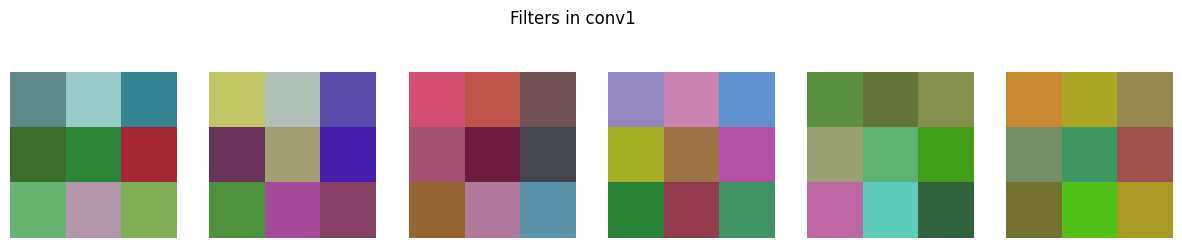

In [35]:
import matplotlib.pyplot as plt

# Get the weights and normalize to [0, 1]
#这一句是获取我们的第一层卷积层的图像权重，并且复制后放入cpu中
#matplotlib只可以在cpu中运行
filters = net.conv1.weight.data.clone().cpu()
#这是进行归一化，方便显示，也可以不做
filters = (filters - filters.min()) / (filters.max() - filters.min())

# Plot first 6 filters
#这里面的fig是画布对象，axes是每一个子图对象
#axes = [axes[0], axes[1], ..., axes[5]]
#每一个axes[i]都是一个子图对象
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    #permute(1, 2, 0)是什么意思？
    #我们的pytorch是以CHW（channel,height,width）这样的形式储存我们的图像的
    #但是在matplotlib中是HWC (height,width,channel),要转换图像方便可视化
    #把原来的第1维（H）放到第0个位置，第2维（W）放到第1个位置第0维（C）放到最后第2个位置
    axes[i].imshow(filters[i].permute(1, 2, 0))  # convert CHW to HWC
    #隐藏坐标轴
    axes[i].axis('off')
plt.suptitle('Filters in conv1')
plt.show()

### Feature Maps (Activations)

Now we visualize how the CNN responds to an image by displaying feature maps generated by the first conv layer.


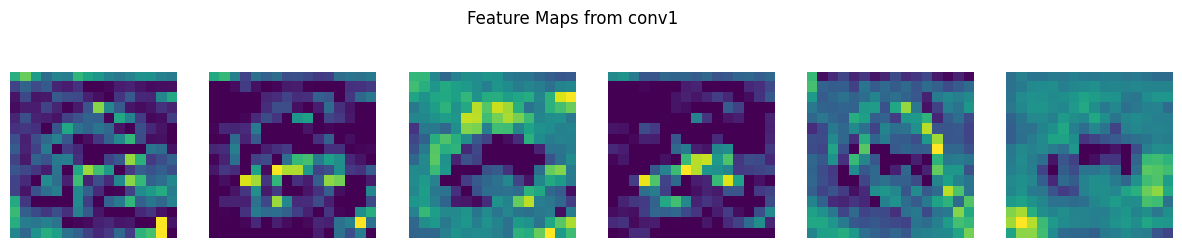

In [36]:
#主要是为了看我们的模型激活之后得到了什么


# Choose one sample image from CIFAR-10
image, label = trainset[0]
#这一步主要是进行了将我的CHW图像加入了我的batch，成为一个tensor
input_img = image.unsqueeze(0).to(device)  # Add batch dimension

#将上面这个batch的tensor放入我们的第一层网络中进行操作
# Pass through first conv layer and visualize
net.eval()
with torch.no_grad():
    activation = net.pool(torch.relu(net.bn1(net.conv1(input_img))))

# Remove batch dimension and convert to CPU
#去掉我们的batch放入cpu中
features = activation.squeeze().cpu()

# Plot first 6 feature maps
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    axes[i].imshow(features[i] ) #cmap='gray'
    axes[i].axis('off')
plt.suptitle('Feature Maps from conv1')
plt.show()

## Using a pretrained model like ResNet18

In this section, we explore a pretrained **ResNet18** model from `torchvision.models`.


Instead of training a CNN from scratch, we can reuse the **feature extraction layers** of a model trained on a large dataset (like ImageNet), and only retrain the final layer(s) for our own task.

**Benefits:**
- Much faster training
- Requires less data
- Often achieves higher accuracy

We use **[ResNet18](https://pytorch.org/hub/pytorch_vision_resnet/)**, a deep residual network, pretrained on ImageNet.

---

In [37]:
# Import ResNet18 from torchvision
from torchvision import models
import torch.nn as nn

# Load pretrained ResNet18
#注意加载的时候指定预训练模型
model = models.resnet18(pretrained=True)

# Freeze all layers except the final layer
for param in model.parameters():
    #获取前面17层的层对象，设置成为不允许更改梯度
    #requires_grad 是所有的Tensor对象的一个属性，控制是否可以获取梯度
    param.requires_grad = False

# Modify the final fully connected layer of ResNet-18 to match CIFAR-10
#In the case of ResNet18, the last layer is nn.Linear(512, 1000)
#called fc, and we get the number of input

num_ftrs = model.fc.in_features


# The new linear layer has num_ftrs input features and 10 output features (for 10 classes)
#更改输出为10个
model.fc = nn.Linear(num_ftrs, 10)

#移动模型到当前的设备
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:

# Training loop
num_epochs = 2
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(valloader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')



Epoch 1/2, Train Loss: 2.6938, Val Loss: 2.7460
Epoch 2/2, Train Loss: 2.6951, Val Loss: 2.7365


###Loss function and Learning Curve
The loss function measures how well a machine learning model's predictions match the actual outcomes, with the goal of minimizing this error during training. The learning curve plots the loss against the number of training epochs, showing the model's performance improvement over time. By visualizing these curves, we can diagnose issues like overfitting or underfitting and adjust the training process accordingly.

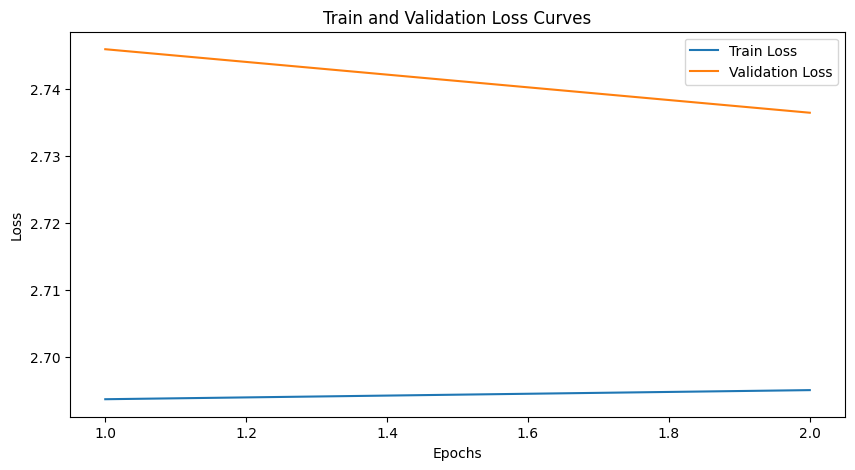

In [42]:
# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Curves')
plt.show()


## Task 1 – Description

Implement a CustomCNN class that builds a convolutional neural network with the following layers:

Conv2d(3, 32, kernel_size=3, padding=1), ReLU, MaxPool2d(2,2)

Conv2d(32, 64, kernel_size=3, padding=1), ReLU, MaxPool2d(2,2)

Flatten

Linear(64×8×8, 128), ReLU, Dropout(0.3)

Linear layer taking 128 inputs with 10 outputs

Note: torch.nn is already imported as nn, and you may use functional components from F.

In [47]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.con1 = nn.Conv2d(in_channels= 3, out_channels= 32, kernel_size= 3, padding= 1)
        

        self.con2 = nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= 3, padding= 1)
        

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(in_features= 64 * 8 * 8, out_features= 128)
        self.dropout_fc = nn.Dropout(0.3)
        self.fc2 = nn.Linear(in_features= 128, out_features= 10)
        # continue

    def forward(self, x):
        
        x = self.pool(self.relu(self.con1(x)))
        x = self.pool(self.relu(self.con2(x)))

        x = x.reshape(x.shape[0], 64 * 8 * 8)

        x = self.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x
        # continue


---

*End of Task 1. Copy your final code to **Homework 3 - Code** on **NextIlearn***